In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import os
import itertools

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

In [22]:
!pip install gdown
import gdown
url = 'https://drive.google.com/file/d/1cE_xvREuB4azlA9pFTlxSZ0jSlw-lR05/view?usp=sharing'
!gdown --id 1cE_xvREuB4azlA9pFTlxSZ0jSlw-lR05 -O U-Net.ckpt

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1cE_xvREuB4azlA9pFTlxSZ0jSlw-lR05
From (redirected): https://drive.google.com/uc?id=1cE_xvREuB4azlA9pFTlxSZ0jSlw-lR05&confirm=t&uuid=8785f559-9ddd-4c78-9b2d-ffd92f263d63
To: /kaggle/working/U-Net.ckpt
100%|██████████████████████████████████████| 1.37G/1.37G [00:14<00:00, 94.1MB/s]


## Model

In [23]:
class Downsample(nn.Module):
  """
  Downsample block for U-Net encoder (contracting path)
  - Conv2d with stride=2 to reduce spatial dimensions by half
  - InstanceNorm2d for normalization (optional, typically skipped in first layer)
  - LeakyReLU activation
  """
  def __init__(self, in_ch, out_ch, normalize=True, dropout=0.0):
      super().__init__()
      layers = [
          nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)
      ]

      if normalize:
          layers.append(nn.InstanceNorm2d(out_ch))

      layers.append(nn.LeakyReLU(0.2, inplace=True))

      if dropout:
          layers.append(nn.Dropout(dropout))

      self.model = nn.Sequential(*layers)

  def forward(self, x):
      return self.model(x)

In [24]:
class Upsample(nn.Module):
    """
    Upsample block for U-Net decoder (expanding path)
    - ConvTranspose2d with stride=2 to increase spatial dimensions by 2x
    - InstanceNorm2d for normalization
    - Dropout for regularization (optional)
    - ReLU activation
    """
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        return torch.cat((x, skip_input), 1)


In [25]:
class Generator(nn.Module):
    """
    U-Net Generator for CycleGAN
    Architecture: Encoder-Decoder with skip connections
    Input: 3-channel image (RGB)
    Output: 3-channel image (RGB)
    """
    def __init__(self, in_ch=3, out_ch=3, base_ch=64):
        super(Generator, self).__init__()

        # Encoder (Contracting Path)
        self.down1 = Downsample(in_ch, base_ch, normalize=False)      # 128x128
        self.down2 = Downsample(base_ch, base_ch*2)                   # 64x64
        self.down3 = Downsample(base_ch*2, base_ch*4)                 # 32x32
        self.down4 = Downsample(base_ch*4, base_ch*8, dropout=0.5)    # 16x16
        self.down5 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 8x8
        self.down6 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 4x4
        self.down7 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 2x2

        # Bottleneck
        self.bottleneck = Downsample(base_ch*8, base_ch*8, normalize=False, dropout=0.5)  # 1x1

        # Decoder (Expanding Path)
        self.up1 = Upsample(base_ch*8, base_ch*8, dropout=0.5)        # 2x2
        self.up2 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 4x4
        self.up3 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 8x8
        self.up4 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 16x16
        self.up5 = Upsample(base_ch*16, base_ch*4)                    # 32x32
        self.up6 = Upsample(base_ch*8, base_ch*2)                     # 64x64
        self.up7 = Upsample(base_ch*4, base_ch)                       # 128x128

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(base_ch*2, out_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        # Encoder with skip connections
        d1 = self.down1(x)                # 128x128
        d2 = self.down2(d1)               # 64x64
        d3 = self.down3(d2)               # 32x32
        d4 = self.down4(d3)               # 16x16
        d5 = self.down5(d4)               # 8x8
        d6 = self.down6(d5)               # 4x4
        d7 = self.down7(d6)               # 2x2

        # Bottleneck
        bottleneck = self.bottleneck(d7)  # 1x1

        # Decoder with skip connections (concatenate)
        u1 = self.up1(bottleneck, d7)     # 2x2
        u2 = self.up2(u1, d6)             # 4x4
        u3 = self.up3(u2, d5)             # 8x8
        u4 = self.up4(u3, d4)             # 16x16
        u5 = self.up5(u4, d3)             # 32x32
        u6 = self.up6(u5, d2)             # 64x64
        u7 = self.up7(u6, d1)             # 128x128

        # Final output
        output = self.final(u7)           # 256x256

        return output

In [26]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator for CycleGAN
    - Classifies whether overlapping image patches are real or fake
    - Outputs a matrix of predictions rather than a single value
    - Uses 70x70 receptive field (patch size)
    """
    def __init__(self, in_ch=3, base_ch=64):
        super(Discriminator, self).__init__()

        def conv_block(in_features, out_features, normalize=True):
            layers = [nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_features))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 70x70 PatchGAN
        self.model = nn.Sequential(
            # C64: No normalization in first layer
            *conv_block(in_ch, base_ch, normalize=False),        # 256 → 128
            # C128: With normalization
            *conv_block(base_ch, base_ch*2),                     # 128 → 64
            # C256: With normalization
            *conv_block(base_ch*2, base_ch*4),                   # 64 → 32
            # C512: With normalization, stride=1
            *conv_block(base_ch*4, base_ch*8),                   # 32 → 16
            # Final output layer: Single channel output (patch predictions)
            nn.Conv2d(base_ch*8, 1, kernel_size=4, padding=1)    # 16 → ~14 (patch map)
        )

    def forward(self, x):
        return self.model(x)


In [27]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [28]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location, weights_only=False)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [30]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, adv_coef=1.0, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.adv_coef = adv_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.start_epoch = 0

    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)

    def load_weights(self, ckpt_path):
        ckpt = load_checkpoint(ckpt_path)
        self.start_epoch = ckpt['epoch']
        self.gen_mtp.load_state_dict(ckpt['gen_mtp'])
        self.gen_ptm.load_state_dict(ckpt['gen_ptm'])

## Load model

In [31]:
device = torch.device('cuda')

def load_my_model(path):
    # 1. Initialize the architecture
    model = CycleGAN(3, 3, 1, device)
    
    # 2. Load the weights
    model.load_weights(path)

    return model

In [32]:
import glob

checkpoint_dir = '/kaggle/working'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoints = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))

In [33]:
model = load_my_model(checkpoints[0])

 [*] Loading checkpoint from /kaggle/working/U-Net.ckpt succeed!


## DataLoader

In [34]:
class ImageDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir

        self.photo_filenames = os.listdir(self.photo_dir)

        layers = [transforms.Resize(size), transforms.ToTensor()]
        if normalize:
            layers.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        self.transform = transforms.Compose(layers)

        self.photo_len = len(self.photo_filenames)

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_filenames[idx % self.photo_len])

        photo_img = self.transform(Image.open(photo_path).convert("RGB"))

        return photo_img

    def __len__(self):
        return self.photo_len

In [35]:
img_ds = ImageDataset('/kaggle/input/gan-getting-started/photo_jpg/', normalize=False)

In [50]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [51]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)

    return img

In [52]:
import matplotlib.pyplot as plt

def show_image(photo_img, monet_img):
    f = plt.figure(figsize=(5, 5))
    
    f.add_subplot(1, 2, 1)
    plt.title('Photo')
    plt.imshow(photo_img[0].permute(1, 2, 0))
    
    f.add_subplot(1, 2, 2)
    plt.title('Monet')
    monet_img = unnorm(monet_img)
    plt.imshow(monet_img[0].permute(1, 2, 0))

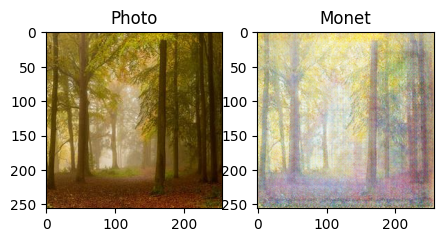

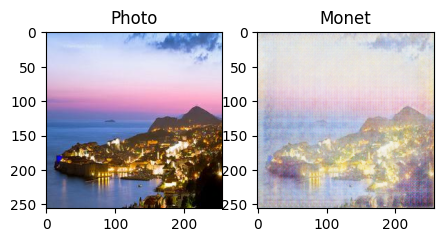

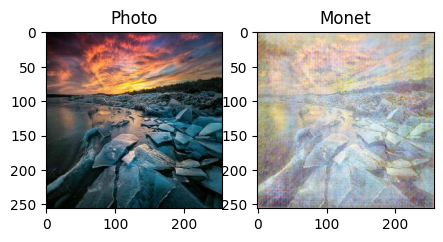

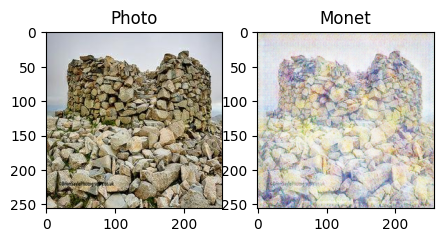

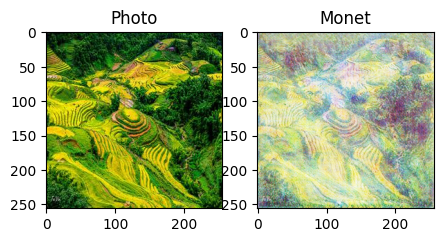

In [53]:
it = iter(img_dl)

for _ in range(5):
    photo_img = next(it)
    pred_monet = model.gen_ptm(photo_img.to(device)).cpu().detach()
    show_image(photo_img, pred_monet)

In [54]:
# Create a directory for images
os.makedirs('../images', exist_ok=True)

it = iter(img_dl)
print(len(it))
# Generate 7,000+ images
photo_path = '/kaggle/input/gan-getting-started/photo_jpg/'
for i in range(len(it)):
    # Preprocess, Predict with model, Postprocess
    photo_img = next(it)
    
    pred_monet = model.gen_ptm(photo_img.to(device)).cpu().detach()
    # show_image(photo_img, pred_monet)
    # Save as JPG
    img_array = pred_monet[0].permute(1, 2, 0).numpy()
    img_array = (img_array * 255).clip(0, 255).astype('uint8')
    im = Image.fromarray(img_array)
    im.save(f"../images/{i+1}.jpg")
    if (i + 1) % 500 == 0:
        print(f'{i + 1} is generated')


7038
500 is generated
1000 is generated
1500 is generated
2000 is generated
2500 is generated
3000 is generated
3500 is generated
4000 is generated
4500 is generated
5000 is generated
5500 is generated
6000 is generated
6500 is generated
7000 is generated


In [43]:
# import subprocess

# subprocess.run(['zip', '-rq', 'images.zip', '../images'])
# print('zip done')

zip done


In [55]:
import shutil
import os

# Define the folder path
folder_to_zip = '../images'
output_filename = 'images' # Will result in images.zip

# Use shutil for a more 'Pythonic' and robust zipping process
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"Zip complete! Archive size: {os.path.getsize('images.zip') / 1024**2:.2f} MB")

Zip complete! Archive size: 143.80 MB
